In [78]:
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Configurar o estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

# Análise e Processamento de Imagens DICOM

DICOM (Digital Imaging and Communications in Medicine) é o padrão internacional para imagens médicas e informações relacionadas. É utilizado universalmente em hospitais e clínicas para:

- Armazenamento de imagens médicas (raio-X, tomografia, ressonância magnética, etc.)
- Transmissão de imagens entre diferentes sistemas
- Visualização e processamento de imagens
- Armazenamento de metadados do paciente e do exame

Cada arquivo DICOM contém:
1. Metadados do paciente (nome, idade, sexo, etc.)
2. Informações do exame (data, tipo de modalidade, etc.)
3. Dados técnicos do equipamento
4. A imagem médica em si

Este notebook demonstra como processar e analisar arquivos DICOM, extraindo tanto os metadados quanto as imagens para análise posterior.

## 1. Pré-processamento de Imagens DICOM

Nesta seção vamos:
- Ler múltiplos arquivos DICOM de um diretório
- Extrair metadados relevantes
- Processar as imagens contidas nos arquivos

In [79]:
def processar_dicom_em_lote(diretorio):
    """Processa todos os arquivos DICOM em um diretório."""
    # Lista para armazenar os metadados
    metadados = []
    # Lista para armazenar as imagens
    imagens = []
    
    # Listar todos os arquivos .dcm no diretório
    arquivos_dicom = [f for f in os.listdir(diretorio) if f.endswith('.dcm')]
    
    for arquivo in arquivos_dicom:
        caminho_completo = os.path.join(diretorio, arquivo)
        try:
            # Ler arquivo DICOM
            ds = pydicom.dcmread(caminho_completo)
            
            # Extrair metadados básicos
            metadado = {
                'arquivo': arquivo,
                'paciente_nome': str(ds.get('PatientName', 'Desconhecido')),
                'paciente_id': str(ds.get('PatientID', 'Desconhecido')),
                'idade': str(ds.get('PatientAge', 'Desconhecido')),
                'sexo': str(ds.get('PatientSex', 'Desconhecido')),
                'modalidade': str(ds.get('Modality', 'Desconhecido')),
                'data_estudo': str(ds.get('StudyDate', 'Desconhecido')),
                'fabricante': str(ds.get('Manufacturer', 'Desconhecido')),
                'num_frames': str(ds.get('NumberOfFrames', 1))
            }
            
            # Extrair imagem (primeiro frame se houver múltiplos)
            if hasattr(ds, 'pixel_array'):
                if len(ds.pixel_array.shape) == 3:
                    imagem = ds.pixel_array[0]
                else:
                    imagem = ds.pixel_array
                imagens.append(imagem)
            
            metadados.append(metadado)
            
        except Exception as e:
            print(f'Erro ao processar {arquivo}: {str(e)}')
    
    return pd.DataFrame(metadados), imagens

In [80]:
import os
import pydicom
import numpy as np
import pandas as pd
from PIL import Image

def criar_diretorios():
    """Cria os diretórios necessários para o projeto."""
    diretorios = [
        'imagens_convertidas/originais',
        'imagens_convertidas/normalizadas'
    ]
    for dir in diretorios:
        os.makedirs(dir, exist_ok=True)
        print(f'Diretório criado/verificado: {dir}')

def salvar_imagem(imagem, nome_arquivo, tipo='original'):
    """Salva uma imagem em formato PNG."""
    # Normalizar para 0-255
    img_normalizada = ((imagem - imagem.min()) * (255.0 / (imagem.max() - imagem.min()))).astype(np.uint8)
    img_pil = Image.fromarray(img_normalizada)
    
    # Definir caminho baseado no tipo
    subdir = 'originais' if tipo == 'original' else 'normalizadas'
    caminho = os.path.join('imagens_convertidas', subdir, f'{nome_arquivo}.png')
    
    img_pil.save(caminho)
    return caminho

def processar_dicom_em_lote(diretorio):
    """Processa todos os arquivos DICOM em um diretório."""
    # Criar diretórios necessários
    criar_diretorios()
    
    # Lista para armazenar os metadados
    metadados = []
    # Lista para armazenar as imagens
    imagens = []
    
    # Listar todos os arquivos .dcm no diretório
    arquivos_dicom = [f for f in os.listdir(diretorio) if f.endswith('.dcm')]
    
    for arquivo in arquivos_dicom:
        caminho_completo = os.path.join(diretorio, arquivo)
        try:
            # Ler arquivo DICOM
            ds = pydicom.dcmread(caminho_completo)
            
            # Extrair metadados básicos
            metadado = {
                'arquivo': arquivo,
                'paciente_nome': str(ds.get('PatientName', 'Desconhecido')),
                'paciente_id': str(ds.get('PatientID', 'Desconhecido')),
                'idade': str(ds.get('PatientAge', 'Desconhecido')),
                'sexo': str(ds.get('PatientSex', 'Desconhecido')),
                'modalidade': str(ds.get('Modality', 'Desconhecido')),
                'data_estudo': str(ds.get('StudyDate', 'Desconhecido')),
                'fabricante': str(ds.get('Manufacturer', 'Desconhecido')),
                'num_frames': str(ds.get('NumberOfFrames', 1))
            }
            
            # Extrair imagem (primeiro frame se houver múltiplos)
            if hasattr(ds, 'pixel_array'):
                if len(ds.pixel_array.shape) == 3:
                    imagem = ds.pixel_array[0]
                else:
                    imagem = ds.pixel_array
                
                # Salvar imagem original
                nome_base = os.path.splitext(arquivo)[0]
                caminho_salvo = salvar_imagem(imagem, nome_base, 'original')
                metadado['caminho_imagem'] = caminho_salvo
                
                imagens.append(imagem)
            
            metadados.append(metadado)
            
        except Exception as e:
            print(f'Erro ao processar {arquivo}: {str(e)}')
    
    return pd.DataFrame(metadados), imagens

# Configurar o diretório dos arquivos DICOM
dicom_dir = r'C:\Users\luis_\Downloads\DCM_Images-20231213T092329Z-001\DCM_Images'

# Processar os arquivos
df_metadados, lista_imagens = processar_dicom_em_lote(dicom_dir)

print(f'Processados {len(df_metadados)} arquivos DICOM')
df_metadados.head()

Diretório criado/verificado: imagens_convertidas/originais
Diretório criado/verificado: imagens_convertidas/normalizadas
Processados 338 arquivos DICOM


,arquivo,paciente_nome,paciente_id,idade,sexo,modalidade,data_estudo,fabricante,num_frames,caminho_imagem
0,PPMI_101179_MR_2D_GRE_MT__br_raw_2022041921350...,DE-IDENTIFIED,101179,052Y,F,MR,20220404,Philips Medical Systems,80,imagens_convertidas\originais\PPMI_101179_MR_2...
1,PPMI_101492_MR_rsfMRI_RL__br_raw_2021091622484...,DE-IDENTIFIED,101492,051Y,M,MR,20210525,Philips Medical Systems,9600,imagens_convertidas\originais\PPMI_101492_MR_r...
2,PPMI_101492_MR_rsfMRI_RL__br_raw_2021091622484...,DE-IDENTIFIED,101492,051Y,M,MR,20210525,Philips Medical Systems,9600,imagens_convertidas\originais\PPMI_101492_MR_r...
3,PPMI_103542_MR_rsfMRI_LR__br_raw_2022010612504...,DE-IDENTIFIED,103542,057Y,,MR,20210928,SIEMENS,1,imagens_convertidas\originais\PPMI_103542_MR_r...
4,PPMI_103542_MR_rsfMRI_LR__br_raw_2022010612511...,DE-IDENTIFIED,103542,057Y,,MR,20210928,SIEMENS,1,imagens_convertidas\originais\PPMI_103542_MR_r...


## 2. Normalização das Imagens e Dados

A normalização é um passo crucial no processamento de imagens médicas por várias razões:

1. **Padronização dos Valores**: Diferentes equipamentos DICOM podem usar diferentes escalas de intensidade.
2. **Melhoria do Contraste**: Ajuda a destacar detalhes importantes nas imagens.
3. **Preparação para ML**: Algoritmos de machine learning funcionam melhor com dados normalizados.

Nesta seção vamos:
- Normalizar os valores de pixel para o intervalo [0, 1]
- Aplicar técnicas de melhoria de contraste usando percentis
- Corrigir codificação de texto nos metadados
- Salvar as imagens normalizadas

In [81]:
def normalizar_imagem(imagem):
    """Normaliza os valores de pixel para o intervalo [0, 1]."""
    if imagem.max() == imagem.min():
        return np.zeros_like(imagem, dtype=np.float32)
    return (imagem - imagem.min()) / (imagem.max() - imagem.min())

def ajustar_contraste(imagem, percentil_min=2, percentil_max=98):
    """Ajusta o contraste da imagem usando percentis.
    
    Args:
        imagem: Array numpy com a imagem
        percentil_min: Percentil inferior para corte (padrão: 2)
        percentil_max: Percentil superior para corte (padrão: 98)
    
    Returns:
        Imagem normalizada com contraste ajustado
    """
    p_min, p_max = np.percentile(imagem, [percentil_min, percentil_max])
    imagem_ajustada = np.clip(imagem, p_min, p_max)
    return normalizar_imagem(imagem_ajustada)

# Processar todas as imagens
imagens_normalizadas = []
for i, (img, metadado) in enumerate(zip(lista_imagens, df_metadados.itertuples())):
    img_norm = ajustar_contraste(img)
    imagens_normalizadas.append(img_norm)
    
    # Salvar imagem normalizada
    nome_base = os.path.splitext(metadado.arquivo)[0]
    caminho_salvo = salvar_imagem(img_norm, f'{nome_base}_norm', 'normalizada')
    df_metadados.at[i, 'caminho_imagem_normalizada'] = caminho_salvo

# Normalizar dados textuais (remover caracteres especiais, etc)
df_metadados = df_metadados.apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii') if x.dtype == 'object' else x)

# Visualizar exemplo de umas das imagens

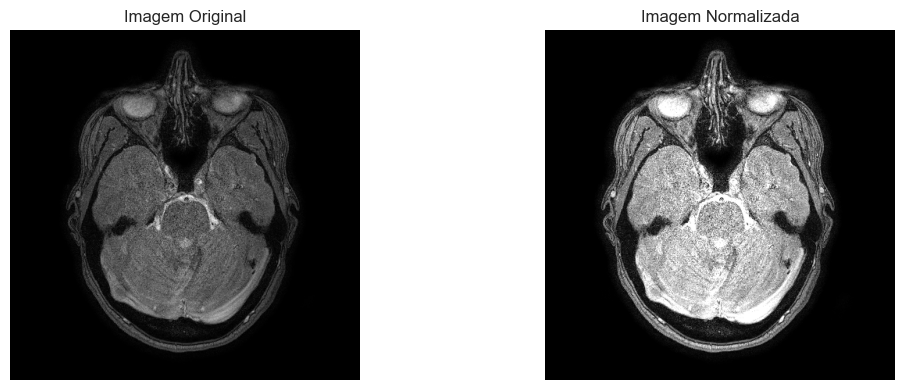

In [82]:
if len(lista_imagens) > 0:
    plt.figure(figsize=(12, 4))
    
    plt.subplot(121)
    plt.imshow(lista_imagens[0], cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(imagens_normalizadas[0], cmap='gray')
    plt.title('Imagem Normalizada')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

## 3. Análise Exploratória dos Dados

A análise exploratória dos dados (EDA) é fundamental para entender as características do nosso conjunto de dados DICOM. Vamos analisar:

### Metadados
1. **Estatísticas Descritivas**: Resumo estatístico dos dados numéricos
2. **Distribuição por Modalidade**: Entender quais tipos de exames temos (CT, MRI, etc.)
3. **Distribuição por Sexo**: Análise demográfica básica

Os gráficos a seguir nos ajudarão a identificar:
- Padrões nos dados
- Possíveis anomalias
- Distribuições importantes para análise posterior

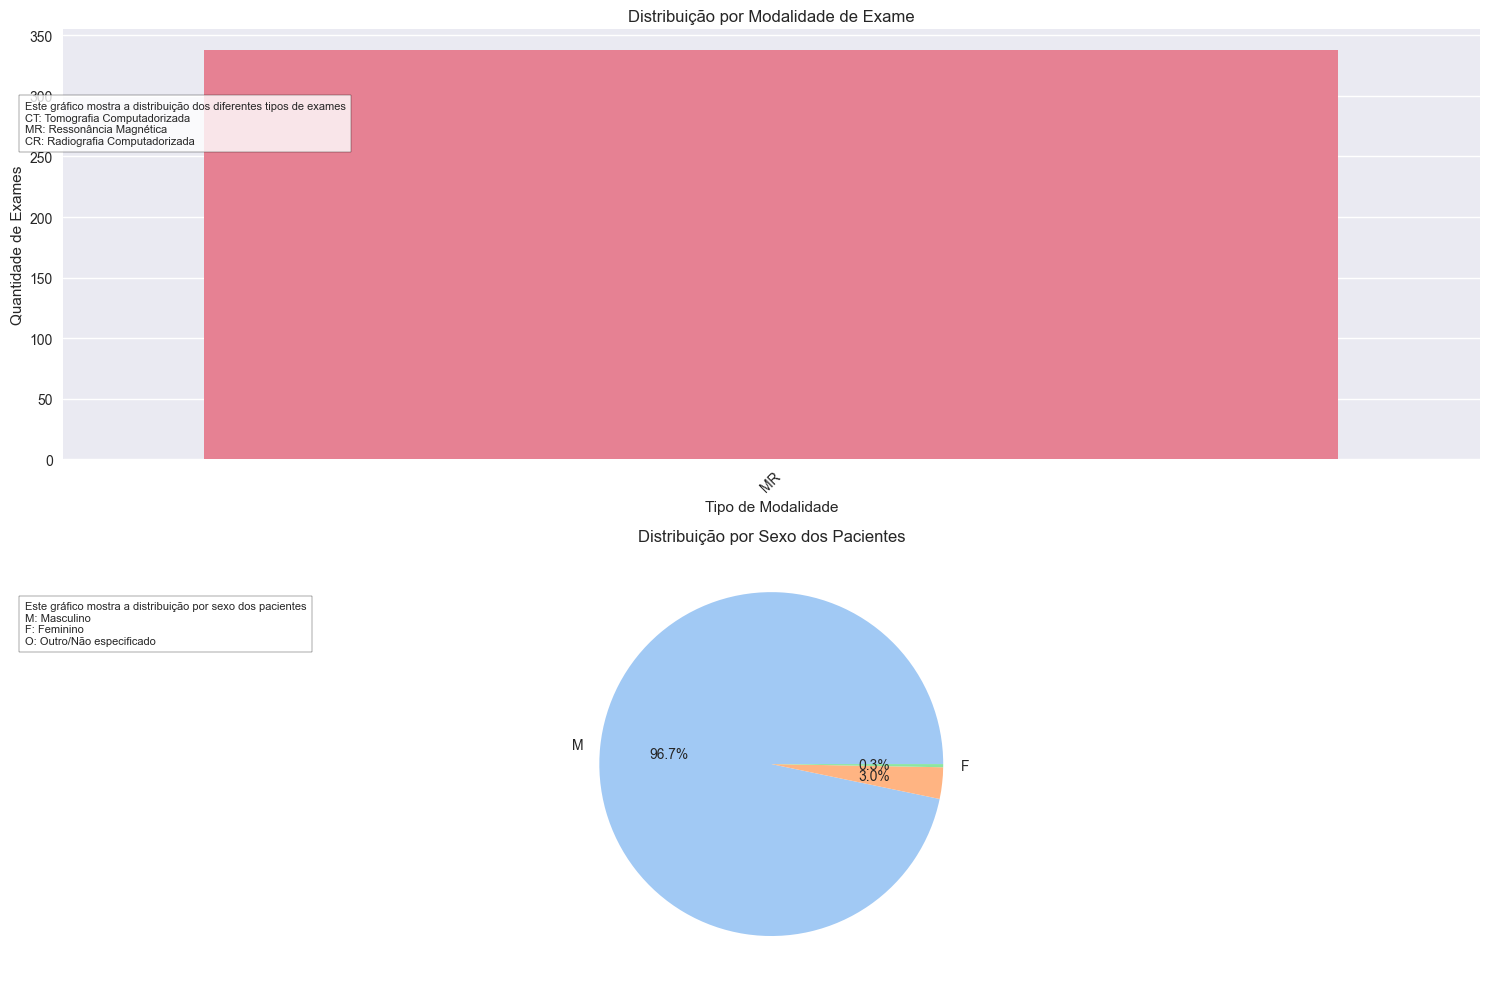

In [83]:

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
sns.barplot(x=df_metadados['modalidade'].value_counts().index, 
           y=df_metadados['modalidade'].value_counts().values)
plt.title('Distribuição por Modalidade de Exame')
plt.xlabel('Tipo de Modalidade')
plt.ylabel('Quantidade de Exames')
plt.xticks(rotation=45)

plt.figtext(0.02, 0.85, 
           'Este gráfico mostra a distribuição dos diferentes tipos de exames\n' +
           'CT: Tomografia Computadorizada\n' +
           'MR: Ressonância Magnética\n' +
           'CR: Radiografia Computadorizada', 
           fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

plt.subplot(2, 1, 2)
sexo_counts = df_metadados['sexo'].value_counts()
plt.pie(sexo_counts, labels=sexo_counts.index, autopct='%1.1f%%', 
        colors=sns.color_palette('pastel'))
plt.title('Distribuição por Sexo dos Pacientes')

plt.figtext(0.02, 0.35, 
           'Este gráfico mostra a distribuição por sexo dos pacientes\n' +
           'M: Masculino\n' +
           'F: Feminino\n' +
           'O: Outro/Não especificado', 
           fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

## 4. Preparação dos Dados para Machine Learning

Nesta seção, preparamos os dados para aplicação de técnicas de Machine Learning. O processo envolve extrair características numéricas (features) das imagens que possam ser úteis para análise e classificação.

### Extração de Features
Extraímos as seguintes características estatísticas das imagens:

1. **Média de Intensidade**:
   - Representa o brilho médio da imagem
   - Valores mais altos indicam imagens mais claras
   - Valores mais baixos indicam imagens mais escuras
   - Útil para identificar o nível geral de exposição da imagem

2. **Desvio Padrão**:
   - Mede a variação dos valores de pixel em relação à média
   - Desvio alto: imagem com muito contraste (muitas áreas claras e escuras)
   - Desvio baixo: imagem mais uniforme
   - Ajuda a identificar a quantidade de detalhes na imagem

3. **Mediana**:
   - O valor central de todos os pixels
   - Menos sensível a valores extremos que a média
   - Útil para identificar o tom predominante da imagem

4. **Máximo e Mínimo**:
   - Valores mais alto e mais baixo de pixel na imagem
   - Indica a faixa dinâmica da imagem
   - Ajuda a identificar possíveis problemas de saturação

5. **Variância**:
   - Quadrado do desvio padrão
   - Mede a dispersão dos valores de pixel
   - Valores altos indicam maior heterogeneidade na imagem

6. **Entropia**:
   - Mede a complexidade ou quantidade de informação na imagem
   - Valores altos: imagem com muitos detalhes diferentes
   - Valores baixos: imagem mais simples ou uniforme

### Divisão dos Dados
Para validar nossos modelos de machine learning, dividimos os dados em:

- **Conjunto de Treino (80%)**:
  - Usado para treinar o modelo
  - O modelo aprende os padrões a partir destes dados
  - Maior porção dos dados para melhor aprendizado

- **Conjunto de Teste (20%)**:
  - Usado para avaliar o desempenho do modelo
  - Dados nunca vistos pelo modelo durante o treinamento
  - Simula o uso do modelo em novos dados

### Aplicações Possíveis
Estas features podem ser usadas para:

1. **Classificação de Modalidades**:
   - Identificar automaticamente o tipo de exame (CT, MRI, etc.)
   - Detectar padrões específicos de cada modalidade

2. **Detecção de Anomalias**:
   - Identificar imagens com características incomuns
   - Detectar problemas de qualidade nas imagens

3. **Agrupamento de Imagens Similares**:
   - Encontrar padrões comuns entre diferentes exames
   - Organizar imagens por características semelhantes

In [84]:
def extrair_features_imagem(imagem):
    hist, _ = np.histogram(imagem.flatten(), bins=50, density=True)
    
    return {
        'media_intensidade': np.mean(imagem),
        'desvio_padrao': np.std(imagem),
        'mediana': np.median(imagem),
        'max': np.max(imagem),
        'min': np.min(imagem),
        'variancia': np.var(imagem),
        'entropia': -np.sum(hist * np.log2(hist + 1e-10)) 
    }

features_imagens = [extrair_features_imagem(img) for img in imagens_normalizadas]
df_features = pd.DataFrame(features_imagens)

df_final = pd.concat([df_metadados, df_features], axis=1)

X = df_features 
y = df_metadados['modalidade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('\nInformações sobre os conjuntos de dados:')
print(f'Conjunto de treino: {X_train.shape[0]} amostras')
print(f'Conjunto de teste: {X_test.shape[0]} amostras')
print(f'Número de features: {X_train.shape[1]}')
print('\nFeatures são características numéricas extraídas das imagens que nos ajudam a entender e analisar seu conteúdo. \nPense nelas como "medidas" que descrevem diferentes aspectos da imagem.')
print('\nMédia de Intensidade => É como o "brilho médio" da imagem.')
print('\nDesvio Padrão => Mede quanto os pixels "variam" em relação à média.')
print('\nMediana => O valor do pixel que fica "no meio" quando ordenamos todos os valores. Ajuda a entender o tom predominante da imagem')
print('\nEntropia => Mede a "complexidade" ou "aleatoriedade" da imagem.')
print('\nValor Mínimo => O pixel mais escuro da imagem.')
print('\nDistribuição das classes (modalidades):')
print(y_train.value_counts())


Informações sobre os conjuntos de dados:
Conjunto de treino: 270 amostras
Conjunto de teste: 68 amostras
Número de features: 7

Features são características numéricas extraídas das imagens que nos ajudam a entender e analisar seu conteúdo. 
Pense nelas como "medidas" que descrevem diferentes aspectos da imagem.

Média de Intensidade => É como o "brilho médio" da imagem.

Desvio Padrão => Mede quanto os pixels "variam" em relação à média.

Mediana => O valor do pixel que fica "no meio" quando ordenamos todos os valores. Ajuda a entender o tom predominante da imagem

Entropia => Mede a "complexidade" ou "aleatoriedade" da imagem.

Valor Mínimo => O pixel mais escuro da imagem.

Distribuição das classes (modalidades):
modalidade
MR    270
Name: count, dtype: int64


## 6. Exportação dos Dados para Análise no Apache Superset

Nesta seção, preparamos os dados para análise posterior no Power BI. A exportação é feita em dois arquivos CSV:

### 1. Arquivo de Dados Completos (dados_dicom_processados.csv)
- Combinação de todos os metadados DICOM
- Inclui todas as features extraídas
- Contém caminhos para as imagens processadas
- Data de processamento para controle

### 2. Arquivo de Features (features_imagens.csv)
- Contém apenas as features extraídas das imagens
- Formato otimizado para análise estatística
- Ideal para criação de visualizações no Power BI

Esses arquivos permitem:
- Criar dashboards interativos
- Realizar análises estatísticas avançadas
- Gerar relatórios personalizados
- Acompanhar tendências nos dados

In [85]:
# Preparar dados para exportação
df_export = df_final.copy()

# Converter dados para formatos adequados
df_export['data_processamento'] = pd.Timestamp.now().strftime('%Y-%m-%d')

# Criar pasta dados_processados se não existir
dados_dir = os.path.join(os.getcwd(), 'dados_processados')
os.makedirs(dados_dir, exist_ok=True)

# Caminhos completos para os arquivos
path_dados = os.path.join(dados_dir, 'dados_dicom_processados.csv')
path_features = os.path.join(dados_dir, 'features_imagens.csv')

# Exportar para CSV
df_export.to_csv(path_dados, index=False, encoding='utf-8')
df_features.to_csv(path_features, index=False, encoding='utf-8')

# Verificar se os arquivos foram criados
for path in [path_dados, path_features]:
    if os.path.exists(path):
        print(f'Arquivo criado com sucesso: {path}')
        print(f'Tamanho: {os.path.getsize(path)} bytes')
    else:
        print(f'ERRO: Arquivo não foi criado: {path}')

Arquivo criado com sucesso: e:\courses\uf\CienciaDeDados\JupyterLab\dados_processados\dados_dicom_processados.csv
Tamanho: 158865 bytes
Arquivo criado com sucesso: e:\courses\uf\CienciaDeDados\JupyterLab\dados_processados\features_imagens.csv
Tamanho: 36679 bytes


# Resumo Final do Processamento

In [86]:
print('\n=== Resumo Final do Processamento ===\n')

print(f'Total de imagens processadas: {len(df_metadados)} exames')

print('\nDistribuição por tipo de exame:')
for modalidade, count in df_metadados['modalidade'].value_counts().items():
    print(f'- {modalidade}: {count} imagens')

idades_validas = df_metadados[df_metadados['idade'] != 'Desconhecido']['idade']
if not idades_validas.empty:
    idades_numericas = idades_validas.str.extract(r'(\d+)')[0].astype(float)
    print('\nInformações sobre idade dos pacientes:')
    print(f'- Média de idade: {idades_numericas.mean():.1f} anos')

print('\nArquivos gerados:')
for path in [path_dados, path_features]:
    tamanho = os.path.getsize(path) / 1024 
    print(f'- {os.path.basename(path)}: {tamanho:.1f} KB')



=== Resumo Final do Processamento ===

Total de imagens processadas: 338 exames

Distribuição por tipo de exame:
- MR: 338 imagens

Informações sobre idade dos pacientes:
- Média de idade: 52.7 anos

Arquivos gerados:
- dados_dicom_processados.csv: 155.1 KB
- features_imagens.csv: 35.8 KB


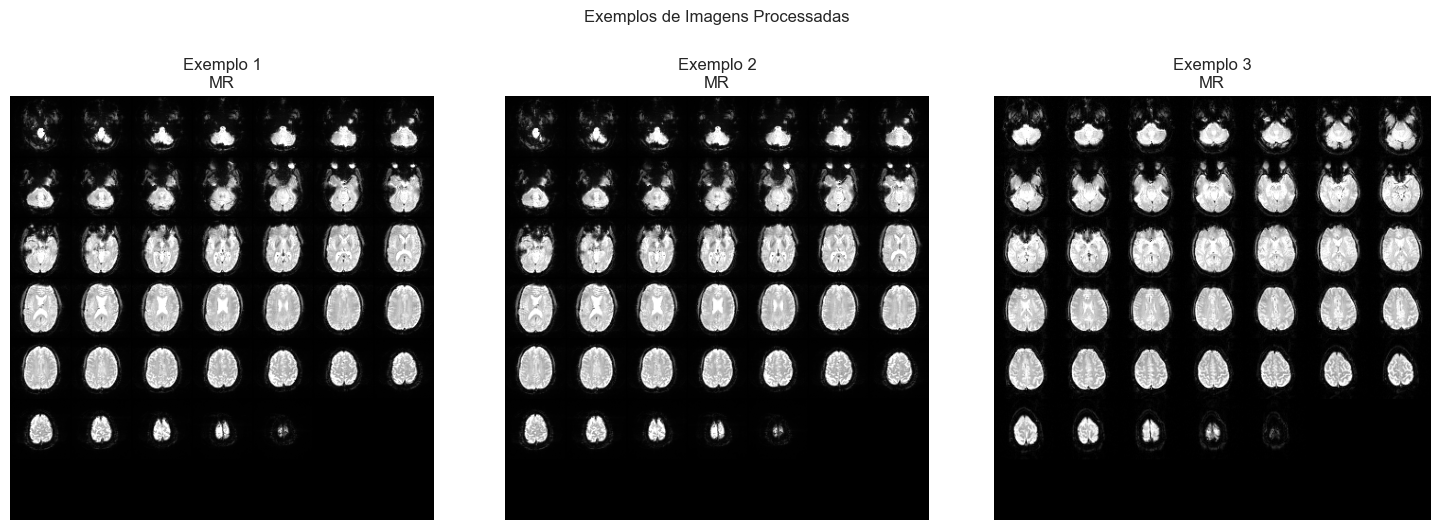

In [87]:
# Mostrar algumas imagens processadas como exemplo final
plt.figure(figsize=(15, 5))

# Pegar 3 imagens aleatórias para mostrar
indices = np.random.choice(len(imagens_normalizadas), min(3, len(imagens_normalizadas)), replace=False)

for i, idx in enumerate(indices):
    plt.subplot(1, 3, i+1)
    plt.imshow(imagens_normalizadas[idx], cmap='gray')
    plt.title(f'Exemplo {i+1}\n{df_metadados.iloc[idx]["modalidade"]}')
    plt.axis('off')

plt.suptitle('Exemplos de Imagens Processadas', y=1.05)
plt.tight_layout()
plt.show()